# Training a neural network with McSnow output

This script applies a DNN to a regression problem 

Much of this follows the basic regression example from the Keras / Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


In [1]:
version = '21'

### Load Tensorflow and other useful modules

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [3]:
tf.random.set_seed(1234)

### Load data from netcdf

In [4]:
import numpy as np
import xarray as xr

In [5]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

data="rimedsnow"

fname1=mdir+edir+'icebox_train_rc_'+data+'.nc'

ds1 = xr.open_dataset(fname1)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:                        (cell: 2150090)
Dimensions without coordinates: cell
Data variables: (12/204)
    time                           (cell) float32 ...
    q_cloud                        (cell) float32 ...
    n_cloud                        (cell) float32 ...
    q_rain                         (cell) float32 ...
    n_rain                         (cell) float32 ...
    q_ice                          (cell) float32 ...
    ...                             ...
    frze_graupel_rain_mass         (cell) float32 ...
    frze_graupel_rain_rmass        (cell) float32 ...
    frze_graupel_rain_rvol         (cell) float32 ...
    frze_graupel_rain_liq          (cell) float32 ...
    rime_graupel_rain_num          (cell) float32 ...
    rime_graupel_rain_mass         (cell) float32 ...
Attributes:
    title:    McSnow ice microphysics box model output pre-processed by NCL
    date:     Mo 30 Mai 2022 17:34:22 CEST
    nfiles:   10013


# Prepare data for training

In [6]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    temp = xr.open_dataset(fname).temp.values
    rho  = xr.open_dataset(fname).rho.values
    ssi  = xr.open_dataset(fname).ssi.values
    q_s  = xr.open_dataset(fname).q_rimedsnow.values
    num_s  = xr.open_dataset(fname).n_rimedsnow.values
    rime_s = xr.open_dataset(fname).rime_rimedsnow.values
    rvol_s = xr.open_dataset(fname).rvol_rimedsnow.values
    liq_s  = xr.open_dataset(fname).liq_rimedsnow.values
    # process rates
    depo_mass = xr.open_dataset(fname).depo_rimedsnow_mass.values   
    # normalize with ssi
    depo_mass = np.where(ssi>1e-4,depo_mass/ssi,np.nan)
    # values of ssi above 1e-2 are mixed-phase and at water saturation
    depo_mass = np.where(ssi<1e-2,depo_mass,np.nan)
    # some numerical lower bounds
    q_min = 1e-15
    n_min = 1e-15
    z_min = 1e-20
    p_min = 1e-20
    # remove melting zone
    depo_mass = np.where(liq_s>q_min,np.nan,depo_mass)      
    # transform everything in log space
    q_s = np.log(q_s, where=q_s>q_min, out=np.nan*q_s)
    num_s  = np.log(num_s, where=num_s>n_min, out=np.nan*q_s)
    rime_s = np.log(rime_s, where=rime_s>q_min, out=np.nan*q_s)
    rvol_s = np.log(rvol_s, where=rvol_s>q_min, out=np.nan*q_s)
    depo_mass = np.log(depo_mass, where=depo_mass>p_min, out=np.nan*depo_mass)
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ q_s, num_s, rime_s, rvol_s, temp, ssi, rho, depo_mass ]))
    dataset = dataset.T
    dataset.columns = [ 'q_s', 'num_s', 'rime_s', 'rvol_s', 'temp', 'ssi', 'rho', 'depo_mass' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [7]:
df = read_and_prepare_data(fname1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater


In [8]:
df.describe()

q_s          num_s         rime_s         rvol_s  \
count  389375.000000  389375.000000  389375.000000  389375.000000   
mean       -5.756279       5.903997      -6.565833     -12.247615   
std         1.580658       2.772481       1.780000       1.750937   
min       -23.020367     -14.234228     -23.160870     -29.711344   
25%        -6.116348       4.577753      -7.224269     -12.781828   
50%        -5.548550       5.339987      -6.364501     -12.063792   
75%        -5.047784       7.701155      -5.559215     -11.362181   
max        -3.510834      14.176536      -3.591136      -8.925537   

                temp            ssi            rho      depo_mass  
count  389375.000000  389375.000000  389375.000000  389375.000000  
mean      265.562927       0.004781       1.015661     -12.341148  
std         5.732778       0.002403       0.096850       1.513092  
min       246.210007       0.000200       0.721000     -31.889179  
25%       262.399994       0.002800       0.953000     -12.608462  
50%       266.950012       0.003600       1.028000     -12.281454  
75%       269.970001       0.006800       1.087000     -11.922318  
max       273.140015       0.009900       1.288000      -5.213030

### Split in training, testing and validation with 70/15/15 rule

In [9]:
msk = np.random.rand(len(df)) < 0.7
dataset_train = df[msk]

df2 = df[~msk]
msk = np.random.rand(len(df2)) < 0.5

dataset_test = df2[msk]
dataset_val = df2[~msk]

### Inspect the data

In [10]:
dataset_train.head()

q_s     num_s    rime_s     rvol_s        temp     ssi    rho  \
26 -7.752819  8.237479 -8.982806 -14.041508  267.700012  0.0098  1.070   
27 -7.752005  8.234486 -8.982169 -14.041258  267.779999  0.0098  1.071   
28 -7.751191  8.231536 -8.981453 -14.041007  267.850006  0.0098  1.073   
30 -7.749635  8.224967 -8.980182 -14.040531  268.000000  0.0098  1.075   
31 -7.748799  8.221586 -8.979466 -14.040268  268.070007  0.0098  1.077   

    depo_mass  
26 -12.785425  
27 -12.782598  
28 -12.779704  
30 -12.774019  
31 -12.771193

In [11]:
dataset_train.describe()

q_s          num_s         rime_s         rvol_s  \
count  272204.000000  272204.000000  272204.000000  272204.000000   
mean       -5.757632       5.899838      -6.567073     -12.249032   
std         1.586524       2.769757       1.783456       1.754244   
min       -23.019472     -14.234228     -23.157408     -29.711344   
25%        -6.115215       4.576748      -7.224393     -12.782469   
50%        -5.549192       5.337202      -6.366827     -12.064322   
75%        -5.048302       7.690709      -5.560202     -11.363472   
max        -3.510834      14.163982      -3.591172      -8.925537   

                temp            ssi            rho      depo_mass  
count  272204.000000  272204.000000  272204.000000  272204.000000  
mean      265.565399       0.004782       1.015672     -12.342184  
std         5.728788       0.002403       0.096729       1.515378  
min       246.240005       0.000200       0.721000     -31.889179  
25%       262.410004       0.002800       0.954000     -12.608884  
50%       266.950012       0.003600       1.028000     -12.281731  
75%       269.959991       0.006800       1.087000     -11.923281  
max       273.140015       0.009900       1.288000      -5.213030

In [12]:
dataset_test.describe()

q_s         num_s        rime_s        rvol_s          temp  \
count  58751.000000  58751.000000  58751.000000  58751.000000  58751.000000   
mean      -5.754809      5.929125     -6.563547    -12.244074    265.540649   
std        1.577696      2.782564      1.784561      1.757951      5.747906   
min      -23.020367    -14.234228    -23.160870    -29.607040    246.210007   
25%       -6.121323      4.579693     -7.223295    -12.777923    262.350006   
50%       -5.546753      5.359694     -6.357094    -12.053643    266.920013   
75%       -5.044986      7.773931     -5.555056    -11.355366    269.980011   
max       -3.511068     14.176536     -3.591136     -8.925838    273.130005   

                ssi           rho     depo_mass  
count  58751.000000  58751.000000  58751.000000  
mean       0.004781      1.015385    -12.336159  
std        0.002405      0.097225      1.515074  
min        0.000200      0.724000    -30.759970  
25%        0.002800      0.953000    -12.606220  
50%        0.003600      1.028000    -12.277783  
75%        0.006800      1.087000    -11.915306  
max        0.009900      1.288000     -5.337646

In [13]:
dataset_val.describe()

q_s         num_s        rime_s        rvol_s          temp  \
count  58420.000000  58420.000000  58420.000000  58420.000000  58420.000000   
mean      -5.751442      5.898102     -6.562359    -12.244577    265.573395   
std        1.556072      2.774919      1.759191      1.728325      5.736173   
min      -23.001255    -14.234228    -23.134394    -29.711264    246.380005   
25%       -6.117493      4.580032     -7.224928    -12.784214    262.399994   
50%       -5.547599      5.334432     -6.364850    -12.071437    266.950012   
75%       -5.048103      7.672583     -5.559299    -11.360291    270.000000   
max       -3.510901     14.130759     -3.591208     -8.958570    273.130005   

                ssi           rho     depo_mass  
count  58420.000000  58420.000000  58420.000000  
mean       0.004779      1.015887    -12.341318  
std        0.002401      0.097035      1.500400  
min        0.000200      0.726000    -30.816891  
25%        0.002900      0.953000    -12.609828  
50%        0.003700      1.028000    -12.284142  
75%        0.006800      1.087000    -11.923902  
max        0.009900      1.288000     -5.554838

### Further reduce data to relevant parameter range

In [14]:
def reduce_data(dataset):
    idx = dataset[ dataset['q_s'] < -20 ].index
    dataset.drop(idx,inplace=True)   
    idx = dataset[ dataset['temp'] > 273 ].index
    dataset.drop(idx,inplace=True)   
    return dataset

In [15]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
dataset_train.describe()

q_s          num_s         rime_s         rvol_s  \
count  263859.000000  263859.000000  263859.000000  263859.000000   
mean       -5.717262       5.958023      -6.531421     -12.205560   
std         1.390877       2.682003       1.629295       1.583708   
min       -19.957937     -14.234228     -21.673811     -28.497023   
25%        -6.106157       4.589285      -7.223384     -12.767894   
50%        -5.545651       5.360447      -6.360848     -12.054004   
75%        -5.043977       7.733158      -5.554604     -11.356478   
max        -3.510834      14.163982      -3.591172      -8.925537   

                temp            ssi            rho      depo_mass  
count  263859.000000  263859.000000  263859.000000  263859.000000  
mean      265.338226       0.004793       1.011979     -12.304575  
std         5.666517       0.002404       0.095509       1.345813  
min       246.240005       0.001400       0.721000     -27.445345  
25%       262.200012       0.002900       0.950000     -12.606313  
50%       266.750000       0.003700       1.025000     -12.281021  
75%       269.709991       0.006800       1.082000     -11.920062  
max       273.000000       0.009900       1.285000      -5.213030

In [17]:
dataset_test.describe()

q_s         num_s        rime_s        rvol_s          temp  \
count  57038.000000  57038.000000  57038.000000  57038.000000  57038.000000   
mean      -5.717449      5.984825     -6.530189    -12.203321    265.324554   
std        1.392302      2.694287      1.636331      1.592500      5.688657   
min      -19.958263    -14.234228    -21.257206    -28.050575    246.210007   
25%       -6.114944      4.592014     -7.222994    -12.766438    262.149994   
50%       -5.542595      5.382566     -6.352865    -12.048975    266.739990   
75%       -5.041190      7.815167     -5.550549    -11.346585    269.730011   
max       -3.511068     14.176536     -3.591136     -8.925838    273.000000   

                ssi           rho     depo_mass  
count  57038.000000  57038.000000  57038.000000  
mean       0.004795      1.011828    -12.301120  
std        0.002407      0.096024      1.351686  
min        0.001400      0.724000    -27.549942  
25%        0.002825      0.950000    -12.605249  
50%        0.003700      1.024000    -12.277995  
75%        0.006800      1.083000    -11.912907  
max        0.009900      1.286000     -5.337646

### Pairplot

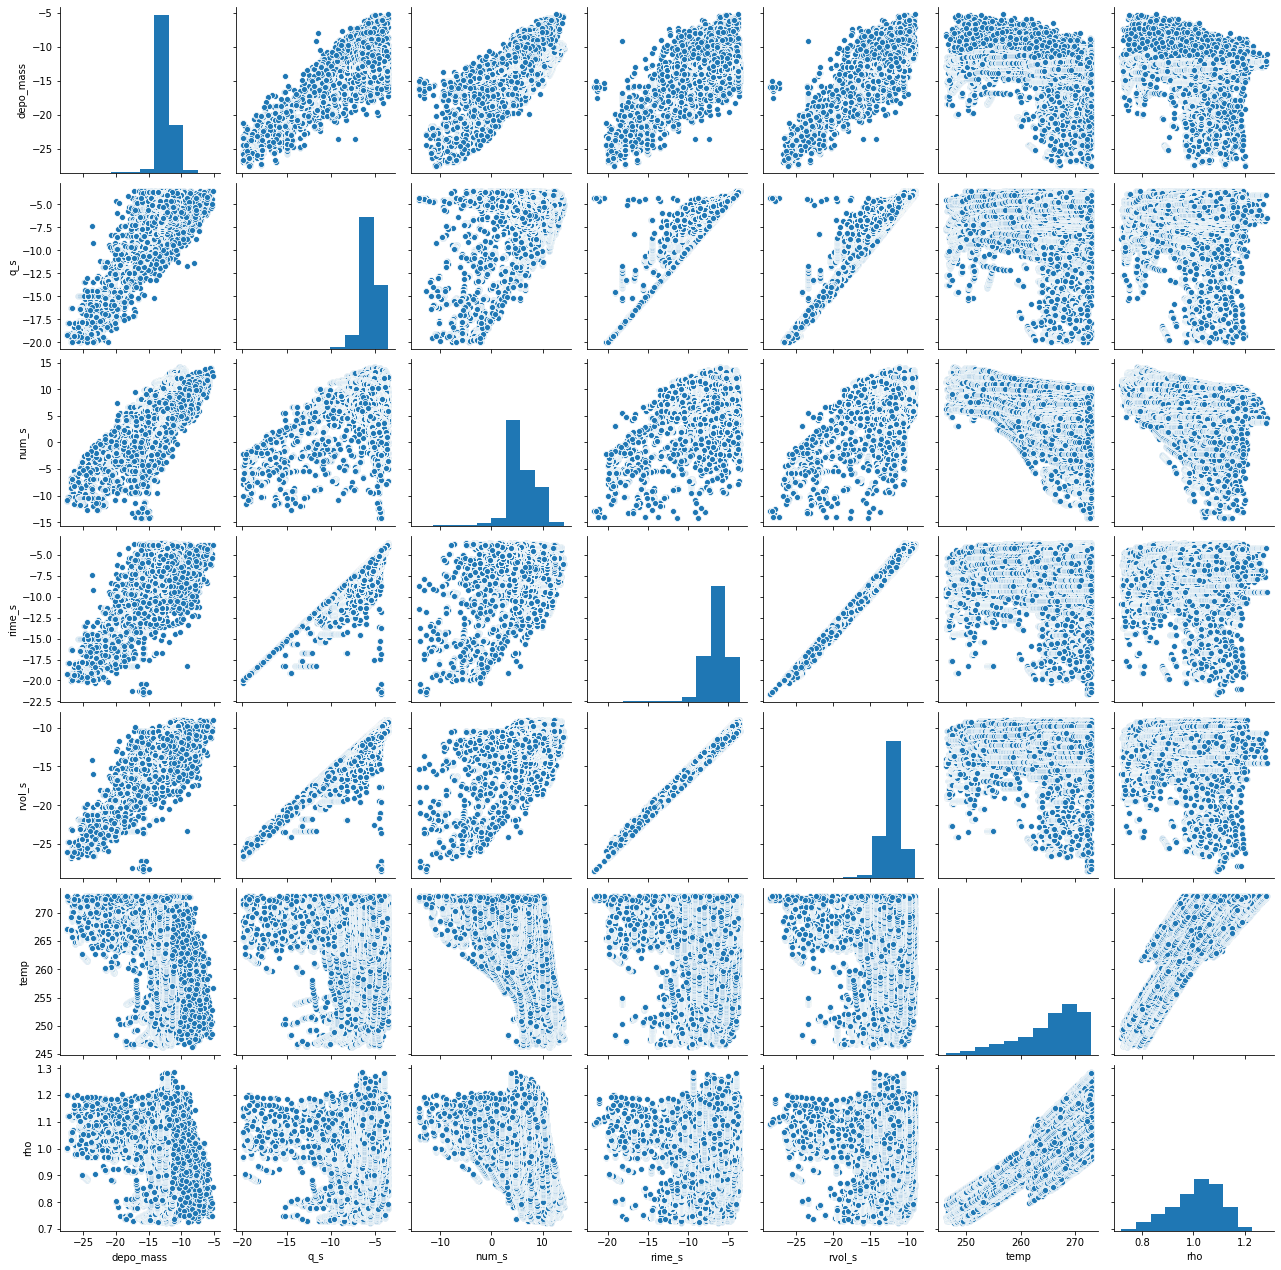

In [18]:
sns.pairplot(dataset_train[["depo_mass","q_s","num_s","rime_s","rvol_s","temp","rho"]], diag_kind="hist")

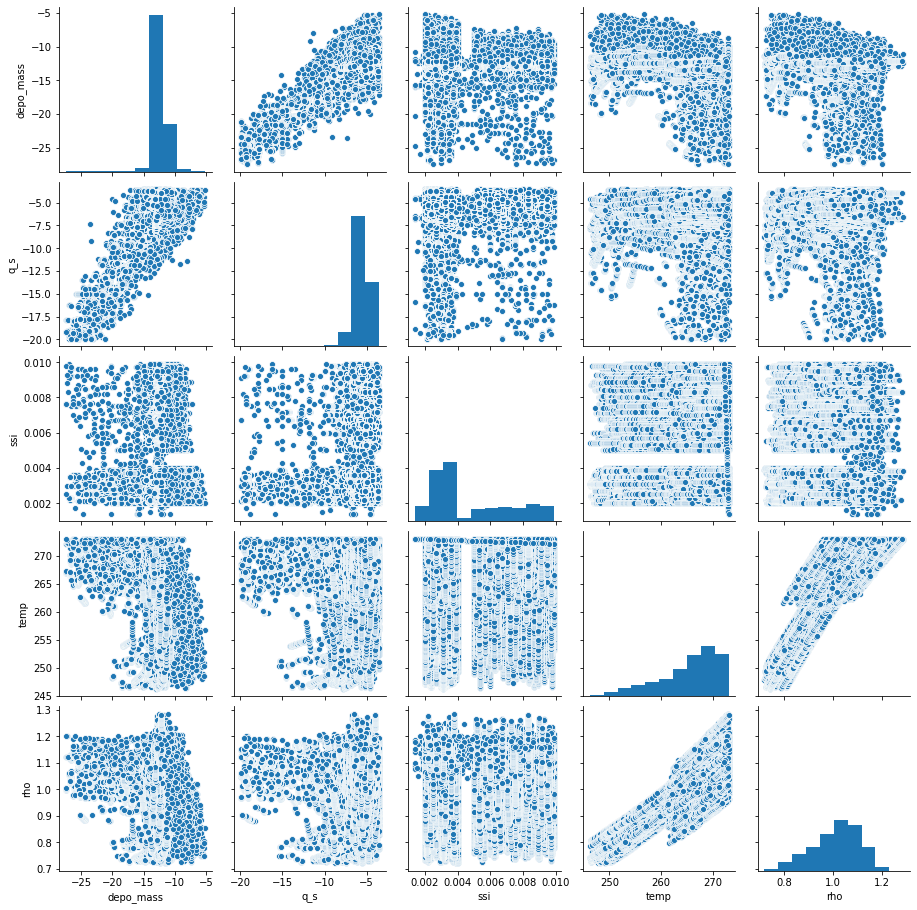

In [19]:
sns.pairplot(dataset_train[["depo_mass","q_s","ssi","temp","rho"]], diag_kind="hist")

## Separate in different dataset with selected sets of predictors

In [20]:
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()

In [21]:
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()

In [22]:
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()

In [23]:
train_dataset1 = train_dataset1.drop(['temp','rho','ssi'], axis=1)
train_dataset2 = train_dataset2.drop(['ssi'], axis=1)
train_dataset3 = train_dataset3.drop(['ssi'], axis=1)

In [24]:
test_dataset1 = test_dataset1.drop(['temp','rho','ssi'], axis=1)
test_dataset2 = test_dataset2.drop(['ssi'], axis=1)
test_dataset3 = test_dataset3.drop(['ssi'], axis=1)

In [25]:
val_dataset1 = val_dataset1.drop(['temp','rho','ssi'], axis=1)
val_dataset2 = val_dataset2.drop(['ssi'], axis=1)
val_dataset3 = val_dataset3.drop(['ssi'], axis=1)

In [26]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("depo_mass")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean       std        min        25%        50%  \
q_s     263859.0  -5.717262  1.390877 -19.957937  -6.106157  -5.545651   
num_s   263859.0   5.958023  2.682003 -14.234228   4.589285   5.360447   
rime_s  263859.0  -6.531421  1.629295 -21.673811  -7.223384  -6.360848   
rvol_s  263859.0 -12.205560  1.583708 -28.497023 -12.767894 -12.054004   

              75%        max  
q_s     -5.043977  -3.510834  
num_s    7.733158  14.163982  
rime_s  -5.554604  -3.591172  
rvol_s -11.356478  -8.925537

In [27]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("depo_mass")
train_stats2 = train_stats2.transpose()
train_stats2

count        mean       std         min         25%         50%  \
q_s     263859.0   -5.717262  1.390877  -19.957937   -6.106157   -5.545651   
num_s   263859.0    5.958023  2.682003  -14.234228    4.589285    5.360447   
rime_s  263859.0   -6.531421  1.629295  -21.673811   -7.223384   -6.360848   
rvol_s  263859.0  -12.205560  1.583708  -28.497023  -12.767894  -12.054004   
temp    263859.0  265.338226  5.666517  246.240005  262.200012  266.750000   
rho     263859.0    1.011979  0.095509    0.721000    0.950000    1.025000   

               75%         max  
q_s      -5.043977   -3.510834  
num_s     7.733158   14.163982  
rime_s   -5.554604   -3.591172  
rvol_s  -11.356478   -8.925537  
temp    269.709991  273.000000  
rho       1.082000    1.285000

In [28]:
train_stats3 = train_dataset3.describe()
train_stats3.pop("depo_mass")
train_stats3 = train_stats3.transpose()
train_stats3

count        mean       std         min         25%         50%  \
q_s     263859.0   -5.717262  1.390877  -19.957937   -6.106157   -5.545651   
num_s   263859.0    5.958023  2.682003  -14.234228    4.589285    5.360447   
rime_s  263859.0   -6.531421  1.629295  -21.673811   -7.223384   -6.360848   
rvol_s  263859.0  -12.205560  1.583708  -28.497023  -12.767894  -12.054004   
temp    263859.0  265.338226  5.666517  246.240005  262.200012  266.750000   
rho     263859.0    1.011979  0.095509    0.721000    0.950000    1.025000   

               75%         max  
q_s      -5.043977   -3.510834  
num_s     7.733158   14.163982  
rime_s   -5.554604   -3.591172  
rvol_s  -11.356478   -8.925537  
temp    269.709991  273.000000  
rho       1.082000    1.285000

### Split features from labels (here we need only one set of labels)

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [29]:
# pop does not work for multiple columns, use copy instead

labels = ['depo_mass']

train_labels = train_dataset1[labels].copy()
train_dataset1.drop(labels, axis=1, inplace=True)

test_labels = test_dataset1[labels].copy()
test_dataset1.drop(labels, axis=1, inplace=True)

val_labels = val_dataset1[labels].copy()
val_dataset1.drop(labels, axis=1, inplace=True)

In [30]:
train_dataset2.drop(labels, axis=1, inplace=True)
test_dataset2.drop(labels, axis=1, inplace=True)
val_dataset2.drop(labels, axis=1, inplace=True)

In [31]:
train_dataset3.drop(labels, axis=1, inplace=True)
test_dataset3.drop(labels, axis=1, inplace=True)
val_dataset3.drop(labels, axis=1, inplace=True)

In [32]:
train_labels.describe()

depo_mass
count  263859.000000
mean      -12.304575
std         1.345813
min       -27.445345
25%       -12.606313
50%       -12.281021
75%       -11.920062
max        -5.213030

In [33]:
train_dataset1.describe()

q_s          num_s         rime_s         rvol_s
count  263859.000000  263859.000000  263859.000000  263859.000000
mean       -5.717262       5.958023      -6.531421     -12.205560
std         1.390877       2.682003       1.629295       1.583708
min       -19.957937     -14.234228     -21.673811     -28.497023
25%        -6.106157       4.589285      -7.223384     -12.767894
50%        -5.545651       5.360447      -6.360848     -12.054004
75%        -5.043977       7.733158      -5.554604     -11.356478
max        -3.510834      14.163982      -3.591172      -8.925537

In [34]:
train_dataset2.describe()

q_s          num_s         rime_s         rvol_s  \
count  263859.000000  263859.000000  263859.000000  263859.000000   
mean       -5.717262       5.958023      -6.531421     -12.205560   
std         1.390877       2.682003       1.629295       1.583708   
min       -19.957937     -14.234228     -21.673811     -28.497023   
25%        -6.106157       4.589285      -7.223384     -12.767894   
50%        -5.545651       5.360447      -6.360848     -12.054004   
75%        -5.043977       7.733158      -5.554604     -11.356478   
max        -3.510834      14.163982      -3.591172      -8.925537   

                temp            rho  
count  263859.000000  263859.000000  
mean      265.338226       1.011979  
std         5.666517       0.095509  
min       246.240005       0.721000  
25%       262.200012       0.950000  
50%       266.750000       1.025000  
75%       269.709991       1.082000  
max       273.000000       1.285000

In [35]:
train_dataset3.describe()

q_s          num_s         rime_s         rvol_s  \
count  263859.000000  263859.000000  263859.000000  263859.000000   
mean       -5.717262       5.958023      -6.531421     -12.205560   
std         1.390877       2.682003       1.629295       1.583708   
min       -19.957937     -14.234228     -21.673811     -28.497023   
25%        -6.106157       4.589285      -7.223384     -12.767894   
50%        -5.545651       5.360447      -6.360848     -12.054004   
75%        -5.043977       7.733158      -5.554604     -11.356478   
max        -3.510834      14.163982      -3.591172      -8.925537   

                temp            rho  
count  263859.000000  263859.000000  
mean      265.338226       1.011979  
std         5.666517       0.095509  
min       246.240005       0.721000  
25%       262.200012       0.950000  
50%       266.750000       1.025000  
75%       269.709991       1.082000  
max       273.000000       1.285000

### Normalize the features

In [36]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)
normed_train_data3 = norm(train_dataset3,train_stats3)

normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)
normed_test_data3 = norm(test_dataset3,train_stats3)

normed_val_data1 = norm(val_dataset1,train_stats1)
normed_val_data2 = norm(val_dataset2,train_stats2)
normed_val_data3 = norm(val_dataset3,train_stats3)

In [37]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean  std        min       25%       50%       75%  \
q_s     263859.0 -5.394043e-08  1.0 -10.238629 -0.279604  0.123383  0.484072   
num_s   263859.0  9.718640e-08  1.0  -7.528794 -0.510342 -0.222809  0.661869   
rime_s  263859.0  3.657574e-07  1.0  -9.293830 -0.424701  0.104691  0.599533   
rvol_s  263859.0 -1.374370e-06  1.0 -10.286908 -0.355074  0.095697  0.536135   

             max  
q_s     1.586357  
num_s   3.059638  
rime_s  1.804614  
rvol_s  2.071103

In [38]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count          mean  std        min       25%       50%       75%  \
q_s     263859.0 -5.394043e-08  1.0 -10.238629 -0.279604  0.123383  0.484072   
num_s   263859.0  9.718640e-08  1.0  -7.528794 -0.510342 -0.222809  0.661869   
rime_s  263859.0  3.657574e-07  1.0  -9.293830 -0.424701  0.104691  0.599533   
rvol_s  263859.0 -1.374370e-06  1.0 -10.286908 -0.355074  0.095697  0.536135   
temp    263859.0  1.229640e-05  1.0  -3.370363 -0.553817  0.249143  0.771508   
rho     263859.0 -3.029280e-07  1.0  -3.046623 -0.648938  0.136330  0.733135   

             max  
q_s     1.586357  
num_s   3.059638  
rime_s  1.804614  
rvol_s  2.071103  
temp    1.352113  
rho     2.858593

In [39]:
normed_train_stats3 = normed_train_data3.describe()
normed_train_stats3 = normed_train_stats3.transpose()
normed_train_stats3

count          mean  std        min       25%       50%       75%  \
q_s     263859.0 -5.394043e-08  1.0 -10.238629 -0.279604  0.123383  0.484072   
num_s   263859.0  9.718640e-08  1.0  -7.528794 -0.510342 -0.222809  0.661869   
rime_s  263859.0  3.657574e-07  1.0  -9.293830 -0.424701  0.104691  0.599533   
rvol_s  263859.0 -1.374370e-06  1.0 -10.286908 -0.355074  0.095697  0.536135   
temp    263859.0  1.229640e-05  1.0  -3.370363 -0.553817  0.249143  0.771508   
rho     263859.0 -3.029280e-07  1.0  -3.046623 -0.648938  0.136330  0.733135   

             max  
q_s     1.586357  
num_s   3.059638  
rime_s  1.804614  
rvol_s  2.071103  
temp    1.352113  
rho     2.858593

### Normalize the labels

In [40]:
train_labels_stats = train_labels.describe()
train_labels_stats = train_labels_stats.transpose()
train_labels_stats

count       mean       std        min        25%        50%  \
depo_mass  263859.0 -12.304575  1.345813 -27.445345 -12.606313 -12.281021   

                 75%      max  
depo_mass -11.920062 -5.21303

In [41]:
normed_train_labels = norm(train_labels,train_labels_stats)
normed_test_labels = norm(test_labels,train_labels_stats)
normed_val_labels = norm(val_labels,train_labels_stats)

# The model

## Build the model

In [42]:
def build_model_sigm(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='sigmoid', input_shape=[ncol]),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


def build_model_tanh(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,nsize,activation,learning_rate):
    if activation == "sigm":
        model = build_model_sigm(ncol,nsize,learning_rate)
    elif activation == "tanh":
        model = build_model_tanh(ncol,nsize,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,nsize,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD_H6":
        model = build_model_relu_SGD_H6(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H6":
        model = build_model_relu_Adam_H6(ncol,nsize,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,nsize,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,nsize,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [43]:

activ = "sigm"
    
#activ = "PReLU"
#activ = "LReLU"
#activ = "tanh"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"
#activ = "ReLU"

model = build_model(5,8,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 48        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________


# Train the model

Use early stopping

In [45]:
# maximum number, but we use early stopping
EPOCHS = 300

# learning rate
learn = 1e-3       # original value is 1e-3, but smaller might be better?

# width of neural net
nsize = 16

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=15)

# for collecting the histories
histories = {}

# make plots bigger than standard layout
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

In [46]:
nsize = 6
activ = "ReLU_Adam"
model1 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history1 = model1.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1810,  mae:0.2226,  mse:0.1810,  val_loss:0.1532,  val_mae:0.1871,  val_mse:0.1532,  
..................................................................

Text(0, 0.5, 'MAE')

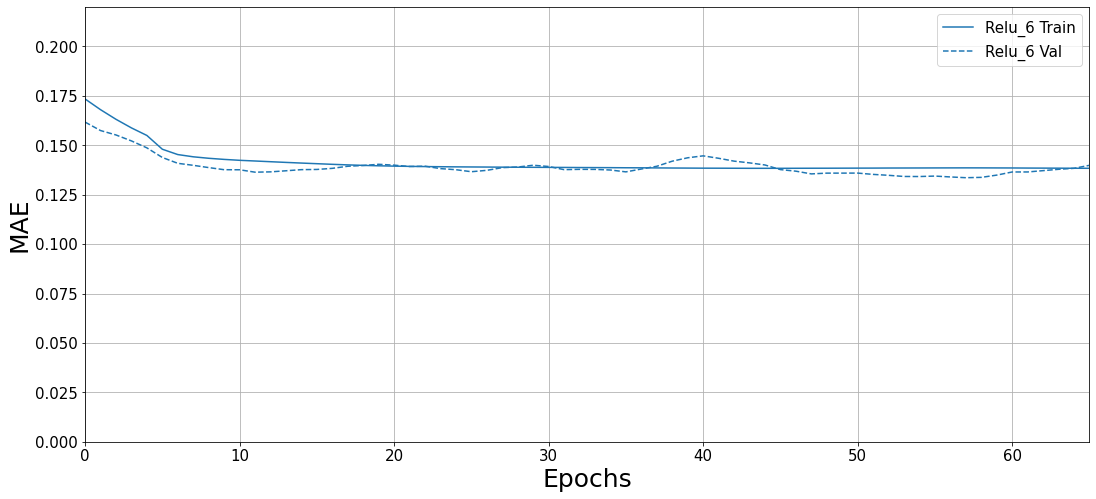

In [47]:
histories['ReLU_6'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.00, 0.22])
plt.ylabel('MAE')

In [48]:
nsize = 8
model2 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history2 = model2.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1763,  mae:0.1987,  mse:0.1763,  val_loss:0.1431,  val_mae:0.1743,  val_mse:0.1431,  
.................................................

Text(0, 0.5, 'MAE')

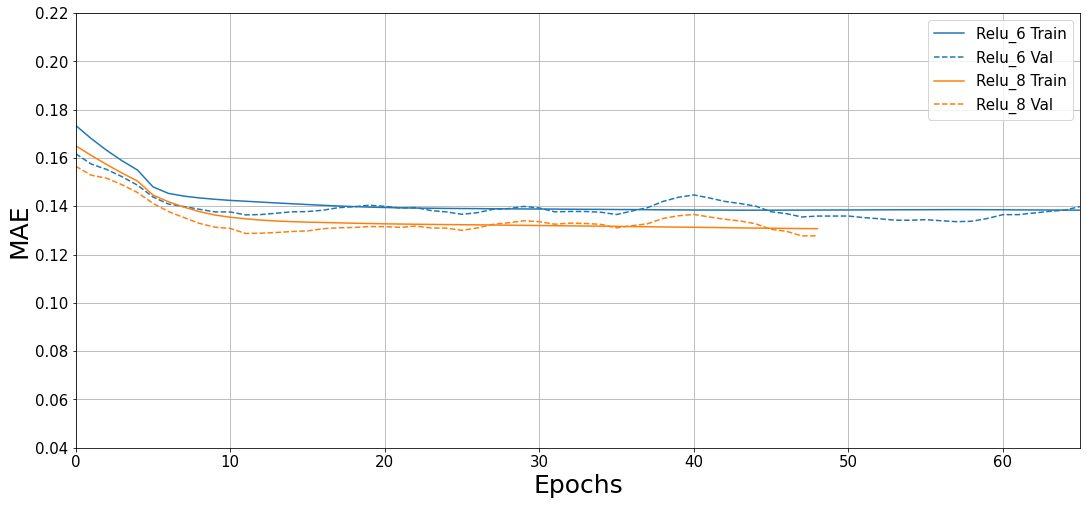

In [49]:
histories['ReLU_8'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.04, 0.22])
plt.ylabel('MAE')

In [50]:
nsize = 16
model3 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history3 = model3.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1514,  mae:0.1737,  mse:0.1514,  val_loss:0.1365,  val_mae:0.1661,  val_mse:0.1365,  
.................................................

Text(0, 0.5, 'MAE')

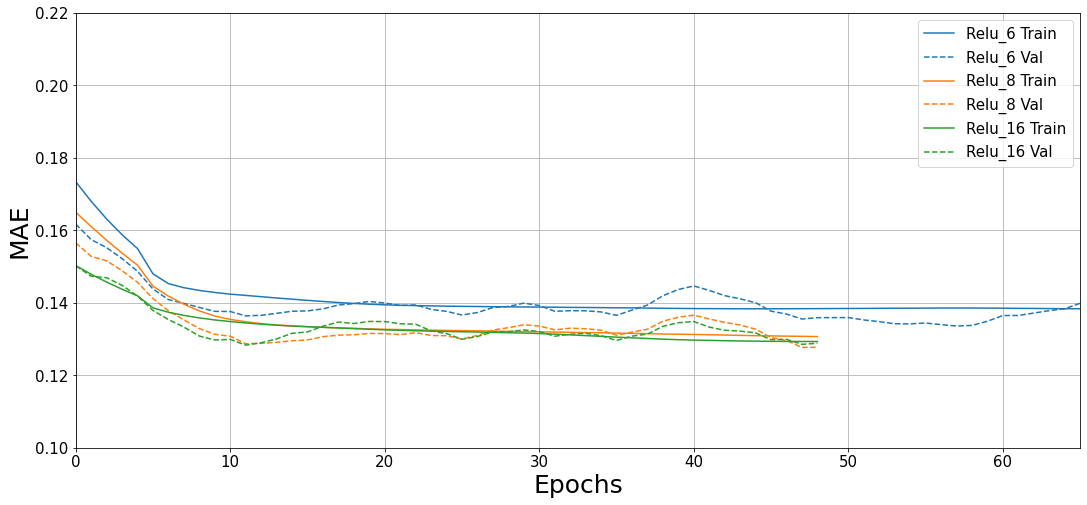

In [51]:
histories['ReLU_16'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.1, 0.22])
plt.ylabel('MAE')

Text(0, 0.5, 'MSE')

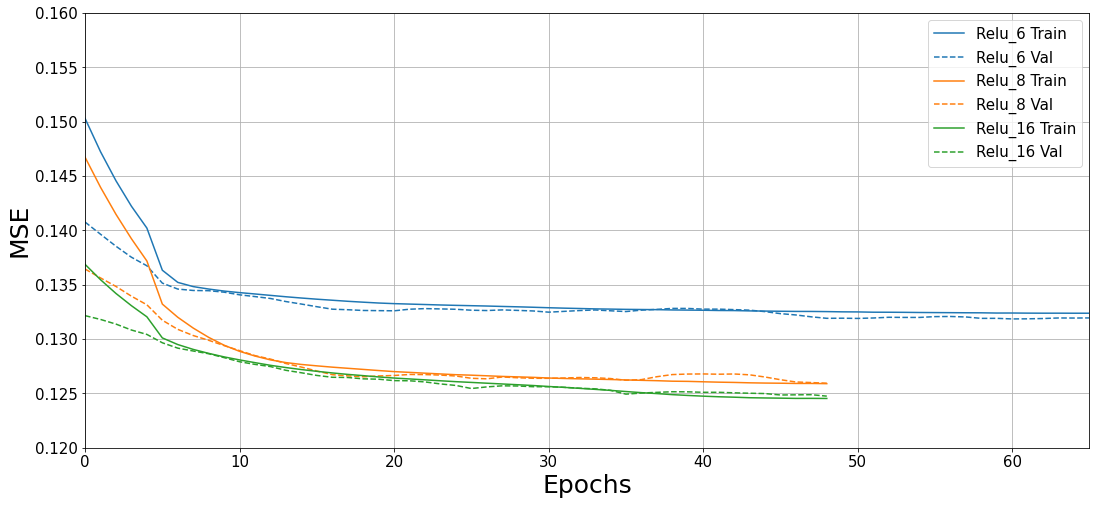

In [53]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mse")
plt.ylim([0.12, 0.16])
plt.ylabel('MSE')

In [54]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data2, normed_test_labels, verbose=1)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

57038/57038 [==============================] - 1s 24us/sample - loss: 0.1300 - mae: 0.1355 - mse: 0.1300
Testing set for model 1, Mean Abs Error:    0.13552


In [55]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:20.5f}".format(mae2))

57038/57038 - 1s - loss: 0.1254 - mae: 0.1293 - mse: 0.1254
Testing set for model 2, Mean Abs Error:              0.12926


In [56]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:20.5f}".format(mae3))

57038/57038 - 1s - loss: 0.1243 - mae: 0.1250 - mse: 0.1243
Testing set for model 3, Mean Abs Error:              0.12504


In [57]:
mae = [ mae1, mae2, mae3 ]
mae

[0.13552432, 0.12925874, 0.12504059]

In [58]:
mse = [ mse1, mse2, mse3 ]
mse

[0.13004413, 0.1253519, 0.12427082]

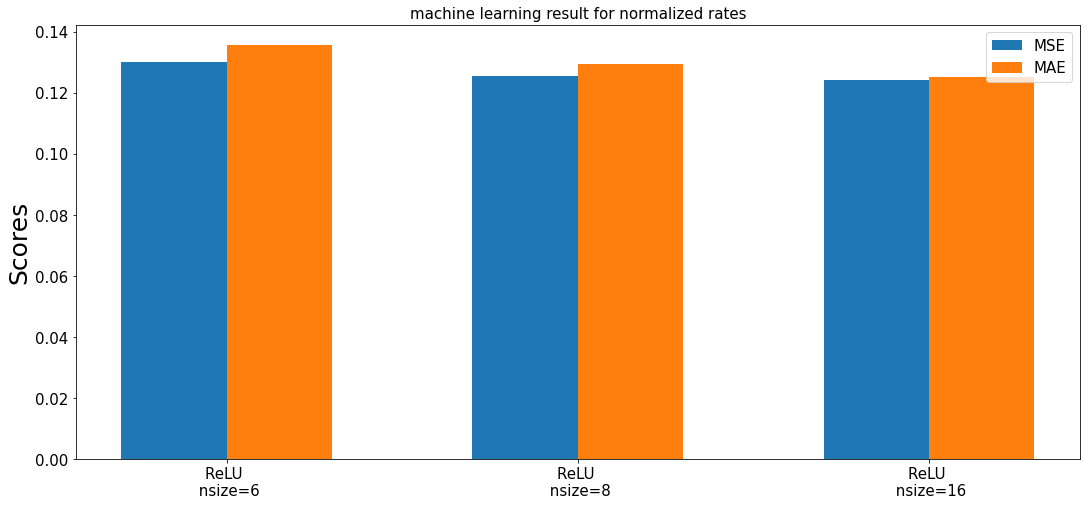

In [59]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

labels = [
 'ReLU \n nsize=6',
 'ReLU \n nsize=8',
 'ReLU \n nsize=16',]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse, width, label='MSE')
rects2 = ax.bar(x + width/2, mae, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('machine learning result for normalized rates')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_ylim(0,3e-8)
ax.legend()

#fig.tight_layout()

plt.show()

# Make predictions

Finally, predict the values using data in the testing set:

In [60]:
test_true_mass  = np.exp(test_labels.pop('depo_mass'))

In [61]:
def backtransform(x,stats):
  return x*stats['std']+stats['mean']

In [62]:
labels = [ "depo_mass" ]

p1 = pd.DataFrame(data=model2.predict(normed_test_data2), columns=labels)

In [63]:
test_predict1 = backtransform(p1,train_labels_stats)

In [64]:
test_predict1.describe()

depo_mass
count  57038.000000
mean     -12.316730
std        1.287686
min      -27.066258
25%      -12.585384
50%      -12.242596
75%      -11.872513
max       -9.140805

In [65]:
test_predict1_mass  = np.exp(test_predict1['depo_mass'])

In [66]:
p2 = pd.DataFrame(data=model2.predict(normed_test_data2), columns=labels)

test_predict2 = backtransform(p2,train_labels_stats)

test_predict2_mass = np.exp(test_predict2['depo_mass'])

In [67]:
p4 = pd.DataFrame(data=model3.predict(normed_test_data2), columns=labels)

test_predict4 = backtransform(p4,train_labels_stats)

test_predict4_mass = np.exp(test_predict4['depo_mass'])

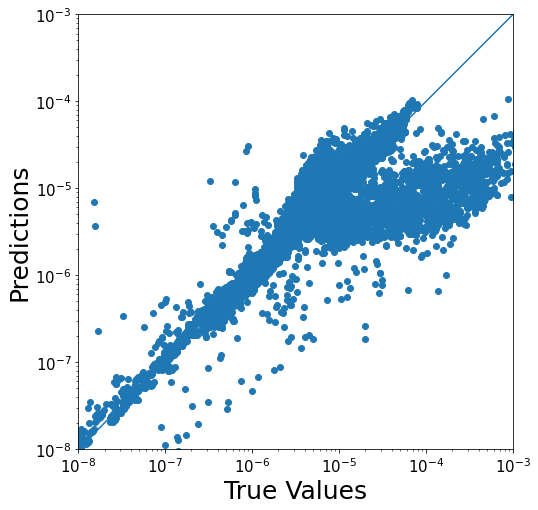

In [68]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

amin, amax = 1e-8, 1e-3
a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict1_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

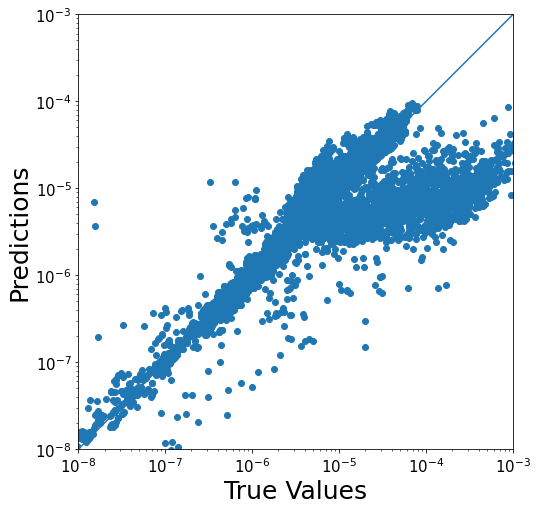

In [69]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict4_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save models to file

In [70]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v2
version

'21'

In [71]:
def save2netcdf(model, features_str, labels_str, features_norm, labels_norm, features_ltf, labels_ltf, outpath, verbose=True):
    # borrowed from Fabian Jakub, LMU Munich
    # https://github.com/tenstream/tenstream/blob/master/misc/LUT_to_Keras.py

    if model is None:
        D = xr.Dataset()
        D.to_netcdf(outpath)
        return

    layers = [ l for l in model.layers if 'Dropout' not in str(type(l)) ]
    if verbose:
        print("Saving model to "+outpath)
        print("  Features:   "+features_str)
        print("  Labels:     "+labels_str)
        for i,l in enumerate(layers):
            print("  Layer {}: {}, {}, Activation: {}".format(i, str(type(l)), l.weights[0].shape,l.activation.__name__))

    D = xr.Dataset()
    D.attrs['Nlayer'] = np.int32(len(layers))
    D.attrs['features']  = features_str
    D.attrs['labels'] = labels_str
    D.attrs['keras_name'] = model.name

    for i, l in enumerate(layers):
        D["w{}".format(i)] = xr.DataArray(l.weights[0].numpy(), dims=("Ninp_{}".format(i), "Nout_{}".format(i)))
        D["b{}".format(i)] = xr.DataArray(l.weights[1].numpy(), dims=("Nout_{}".format(i)))
        D["w{}".format(i)].attrs['activation'] = l.activation.__name__

    # write arrays for logtransform and normalization of input and output data to netcdf
    nout = len(layers)-1
    D["inp_logtransform"] = xr.DataArray(features_ltf, dims=("Ninp_0"))
    D["out_logtransform"] = xr.DataArray(labels_ltf, dims=("Nout_{}".format(nout)))
    D["inp_norm_mean"] = xr.DataArray(features_norm['mean'].values, dims=("Ninp_0"))
    D["inp_norm_std"]  = xr.DataArray(features_norm['std'].values, dims=("Ninp_0"))
    D["out_norm_mean"] = xr.DataArray(labels_norm['mean'].values, dims=("Nout_{}".format(nout)))
    D["out_norm_std"]  = xr.DataArray(labels_norm['std'].values, dims=("Nout_{}".format(nout)))
    
    D.to_netcdf(outpath)

In [72]:

labels   = 'depo_rimedsnow_mass'
logtransformOutput = np.array([True], dtype=bool)


In [73]:
features = 'q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow, T, rho'
logtransformInput  = np.array([True, True, True, True, False, False], dtype=bool)

filename = 'saved_model_v2/depo_rimedsnow_model1_'+version+'.nc'
save2netcdf(model1,features,labels,train_stats2,train_labels_stats,logtransformInput,logtransformOutput,filename)

filename = 'saved_model_v2/depo_rimedsnow_model2_'+version+'.nc'
save2netcdf(model2,features,labels,train_stats2,train_labels_stats,logtransformInput,logtransformOutput,filename)

filename = 'saved_model_v2/depo_rimedsnow_model3_'+version+'.nc'
save2netcdf(model3,features,labels,train_stats2,train_labels_stats,logtransformInput,logtransformOutput,filename)


Saving model to saved_model_v2/depo_rimedsnow_model1_21.nc
  Features:   q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow, T, rho
  Labels:     depo_rimedsnow_mass
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (6, 6), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (6, 6), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (6, 1), Activation: linear
Saving model to saved_model_v2/depo_rimedsnow_model2_21.nc
  Features:   q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow, T, rho
  Labels:     depo_rimedsnow_mass
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (6, 8), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (8, 8), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (8, 1), Activation: linear
Saving model to saved_model_v2/depo_rimedsnow_model3_21.nc
  Features:   q_rimedsnow, n_rimedsnow, rmass_rimedsnow, 